In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
import random
import seaborn as sns
from tqdm import tqdm
import copy
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%%capture
!pip install pycaret

In [3]:
from pycaret.regression import *
from pycaret.utils import check_metric
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


#Statsmodels

Генерируем демонстрационнный датасет

In [4]:
start_age = 25
end_age = 70
age_list = []
income_spouse_list = []
income_list = []
id_list = []
start_id = 1

increment  = 2500

for _ in tqdm(range(20)):
  start_income = 35000
  for age in range(start_age,end_age): 
    id_list.append(start_id)
    # Age
    is_delta = bernoulli(0.7).rvs(size=1)[0]
    size_delta = random.randint(1,7)
    total_age = age + size_delta*is_delta
    age_list.append(total_age)

    # Income spouse
    is_delta = bernoulli(0.7).rvs(size=1)[0]
    size_delta = random.randint(1,10)
    total_income = start_income + increment + is_delta*size_delta*increment
    income_spouse_list.append(total_income)

    # Income 
    is_delta = bernoulli(0.7).rvs(size=1)[0]
    size_delta = random.randint(1,10)
    total_income = total_income + is_delta*size_delta*increment
    income_list.append(total_income)
    
    start_id = start_id + 1 
    start_income = start_income + increment*math.log(age-start_age+1)

100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


In [5]:
data = {'id':id_list, 'age':age_list,'income_spouse':income_spouse_list,'income':income_list}

In [6]:
df = pd.DataFrame(data)

In [7]:
df_train = copy.deepcopy(df.sample(frac=0.5))
df_test = copy.deepcopy(df.loc[~df['id'].isin(df_train['id'])])
print((len(df_train)+len(df_test)) == len(df))

True


In [8]:
df_train.head()

,id,age,income_spouse,income
356,357,73,340085.529454,345085.529454
472,473,47,163677.953380,163677.953380
739,740,44,135849.710468,160849.710468
713,714,63,317420.496536,322420.496536
514,515,44,153349.710468,165849.710468


In [9]:
df_test.head()

,id,age,income_spouse,income
0,1,32,57500.000000,72500.000000
4,5,29,52945.134576,60445.134576
5,6,36,56968.729357,56968.729357
6,7,37,63948.128030,83948.128030
7,8,38,73812.903403,78812.903403


In [10]:
model = smf.ols(formula = 'np.log(income) ~ age + np.log(income_spouse)', data=df_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(income)   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.519e+04
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:08:30   Log-Likelihood:                 539.04
No. Observations:                 450   AIC:                            -1072.
Df Residuals:                     447   BIC:                            -1060.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.07

In [11]:
df_train['y_pred'] = model.predict()
df_train['income_pred'] = df_train['y_pred'].apply(lambda x: round(math.exp(x),0))
df_test['y_pred'] = model.predict(df_test[['age','income_spouse']])
df_test['income_pred'] = df_test['y_pred'].apply(lambda x: round(math.exp(x),0))

In [12]:
df_train.head()

,id,age,income_spouse,income,y_pred,income_pred
356,357,73,340085.529454,345085.529454,12.763043,349075.0
472,473,47,163677.953380,163677.953380,12.063744,173467.0
739,740,44,135849.710468,160849.710468,11.890192,145829.0
713,714,63,317420.496536,322420.496536,12.687418,323650.0
514,515,44,153349.710468,165849.710468,12.000541,162843.0


In [13]:
df_test.head()

,id,age,income_spouse,income,y_pred,income_pred
0,1,32,57500.000000,72500.000000,11.091840,65633.0
4,5,29,52945.134576,60445.134576,11.012838,60648.0
5,6,36,56968.729357,56968.729357,11.088513,65415.0
6,7,37,63948.128030,83948.128030,11.195042,72769.0
7,8,38,73812.903403,78812.903403,11.326971,83031.0


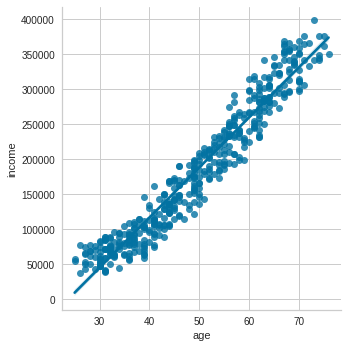

In [14]:
sns.lmplot(x="age", y="income", data=df_test)

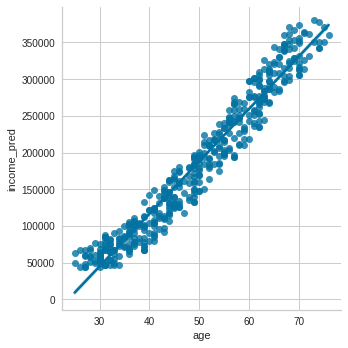

In [15]:
sns.lmplot(x="age", y="income_pred", data=df_test)

In [16]:
print('MSE train: {:.3f}, test: {:.3f}'.format(mean_squared_error(df_train['income'], df_train['income_pred']), 
                                               mean_squared_error(df_test['income'], df_test['income_pred'])))
print('MAE train: {:.3f}, test: {:.3f}'.format(mean_absolute_error(df_train['income'], df_train['income_pred']), 
                                               mean_absolute_error(df_test['income'], df_test['income_pred'])))
print('R^2 train: {:.3f}, test: {:.3f}'.format(r2_score(df_train['income'], df_train['income_pred']), 
                                              r2_score(df_test['income'], df_test['income_pred'])))

MSE train: 72728805.616, test: 76848491.940
MAE train: 7319.187, test: 7720.155
R^2 train: 0.993, test: 0.992


#PyCaret

### Getting the Data

In [17]:
df_train = copy.deepcopy(df.sample(frac=0.5))
df_test = copy.deepcopy(df.loc[~df['id'].isin(df_train['id'])])
print((len(df_train)+len(df_test)) == len(df))

True


### Setting up Environment in PyCaret

In [18]:
exp_reg = setup(data = df_train, target = 'income') 

,Description,Value
0,session_id,6928
1,Target,income
2,Original Data,"(450, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(314, 3)"


### Comparing All Models

In [19]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,7744.3188,7.690519e+07,8745.3629,0.9908,0.0753,0.0573,0.348
lasso,Lasso Regression,7744.1919,7.690291e+07,8745.2337,0.9908,0.0753,0.0573,0.019
ridge,Ridge Regression,7744.1956,7.690271e+07,8745.2228,0.9908,0.0753,0.0573,0.015
en,Elastic Net,7744.4792,7.688778e+07,8744.5390,0.9908,0.0753,0.0574,0.018
lar,Least Angle Regression,7744.1821,7.690284e+07,8745.2279,0.9908,0.0753,0.0573,0.015
llar,Lasso Least Angle Regression,7742.3676,7.687744e+07,8743.8002,0.9908,0.0752,0.0573,0.017
omp,Orthogonal Matching Pursuit,7740.4539,7.670501e+07,8735.1875,0.9908,0.0753,0.0576,0.014
br,Bayesian Ridge,7743.1540,7.678332e+07,8739.9805,0.9908,0.0754,0.0576,0.015
knn,K Neighbors Regressor,7895.0786,8.495543e+07,9193.1996,0.9900,0.0777,0.0584,0.063
huber,Huber Regressor,7881.2924,8.480536e+07,9147.0957,0.9897,0.0781,0.0574,0.032


### Create a Model

In [20]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [21]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7942.3145,8.071482e+07,8984.1426,0.9898,0.0610,0.0488
1,8591.3887,9.608090e+07,9802.0859,0.9854,0.0596,0.0464
2,8205.9326,8.240874e+07,9077.9258,0.9913,0.0909,0.0685
3,7056.5361,6.685386e+07,8176.4209,0.9928,0.0807,0.0595
4,7452.8853,6.739210e+07,8209.2695,0.9919,0.0708,0.0557
5,6598.0269,5.681456e+07,7537.5430,0.9930,0.0700,0.0547
6,7286.4106,7.123027e+07,8439.8027,0.9906,0.0491,0.0382
7,8301.6602,8.805258e+07,9383.6338,0.9889,0.1126,0.0853
8,7549.9780,7.260050e+07,8520.5928,0.9923,0.0753,0.0551
9,8458.0557,8.690363e+07,9322.2119,0.9921,0.0825,0.0613


In [22]:
print(lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)


### Tune a Model

In [23]:
tuned_lr = tune_model(lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7844.5679,7.895805e+07,8885.8340,0.9900,0.0601,0.0479
1,8605.1768,9.666827e+07,9832.0020,0.9853,0.0599,0.0465
2,8236.9209,8.265868e+07,9091.6816,0.9912,0.0916,0.0687
3,6931.2100,6.490843e+07,8056.5771,0.9930,0.0763,0.0569
4,7471.8032,6.811168e+07,8252.9805,0.9918,0.0715,0.0558
5,6587.0273,5.617723e+07,7495.1470,0.9931,0.0699,0.0546
6,7311.6509,7.084886e+07,8417.1768,0.9907,0.0486,0.0385
7,8288.5195,8.797923e+07,9379.7246,0.9889,0.1125,0.0849
8,7574.5625,7.291678e+07,8539.1318,0.9923,0.0750,0.0552
9,8433.5127,8.751498e+07,9354.9443,0.9920,0.0824,0.0604


In [24]:
print(tuned_lr)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)


### Plot a Model

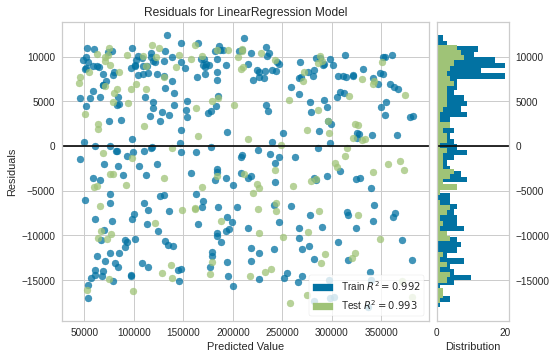

In [25]:
plot_model(tuned_lr)

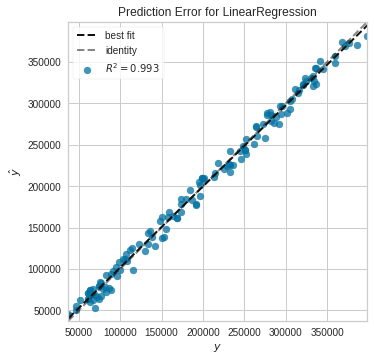

In [26]:
plot_model(tuned_lr, plot = 'error')

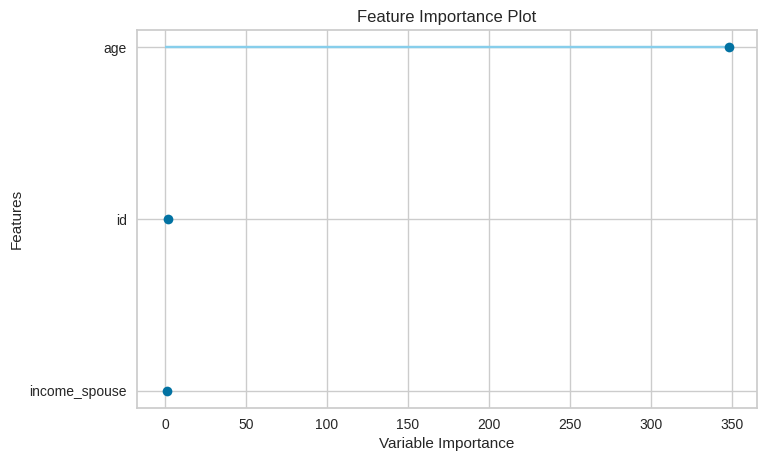

In [27]:
plot_model(tuned_lr, plot='feature')

In [28]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Predict on Test

In [29]:
predict_model(tuned_lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,7393.746582,72558680.0,8518.138672,0.9927,0.073,0.0552


,id,age,income_spouse,income,Label
0,839.0,55.0,207224.359375,232224.359375,217638.187500
1,165.0,55.0,240642.593750,248142.593750,248262.656250
2,675.0,69.0,363293.187500,385793.187500,370646.406250
3,24.0,54.0,166516.687500,191516.687500,177180.093750
4,878.0,47.0,158677.953125,158677.953125,168755.250000
...,...,...,...,...,...
131,773.0,32.0,61312.902344,61312.902344,70764.492188
132,532.0,63.0,276799.250000,276799.250000,286059.343750
133,172.0,64.0,276799.250000,281799.250000,285789.781250
134,33.0,62.0,241394.906250,261394.906250,251186.593750


###Finalize Model for Deployment

In [30]:
final_lr = finalize_model(tuned_lr)

In [31]:
print(final_lr)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)


In [32]:
predict_model(final_lr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,7321.503906,71046384.0,8428.901367,0.9929,0.0721,0.0543


### Predict on Test Data

In [33]:
test_predictions = predict_model(final_lr, data=df_test)
test_predictions.head()

,id,age,income_spouse,income,Label
2,3,29,59232.867951,69232.867951,66015.984375
5,6,36,56968.729357,56968.729357,66042.265625
6,7,37,63948.128030,83948.128030,73063.406250
10,11,37,82761.031433,82761.031433,91144.968750
11,12,36,81255.769615,81255.769615,89386.515625


In [34]:
check_metric(test_predictions.income, test_predictions.Label, 'R2')

0.9925

### Saving the Model

In [35]:
save_model(final_lr,'Final LR Model 24.11.2021')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='income',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy=...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='income')),
                 ('fix_perfect', Remove_100(target='income')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
          

### Loading the Saved Model

In [36]:
saved_final_lr = load_model('Final LR Model 24.11.2021')

Transformation Pipeline and Model Successfully Loaded


In [37]:
new_prediction = predict_model(saved_final_lr, data=df_test)

In [38]:
new_prediction.head()

,id,age,income_spouse,income,Label
2,3,29,59232.867951,69232.867951,66015.984375
5,6,36,56968.729357,56968.729357,66042.265625
6,7,37,63948.128030,83948.128030,73063.406250
10,11,37,82761.031433,82761.031433,91144.968750
11,12,36,81255.769615,81255.769615,89386.515625
